In [5]:
from pycaret.classification import ClassificationExperiment
import pycaret.classification
from pycaret.regression import RegressionExperiment
from pycaret.datasets import get_data
import sys
from scipy.special import softmax
from sklearn.metrics import average_precision_score
from functools import partial
import pandas as pd
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import os

## Classification

In [6]:
def data_classification():
    X, Y = make_classification(n_samples=100, n_features=20, n_informative=10, n_redundant=2, 
                            n_repeated=0, n_classes=2)
    X = pd.DataFrame(X)
    Y = pd.Series(Y)
    Y.name = "label"
    return X, Y
X, Y = data_classification()

In [7]:
data = get_data('diabetes')
new_data = data.drop("Class variable", axis=1)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
X_train, X_test = train_test_split(data, test_size=0.20, random_state=399)

Splits the data and pass it ot the classifcationExperiment Object in pycaret -> it trains classification models for you

In [9]:
s = ClassificationExperiment()
#s.set_config('seed', 1496)
s.setup(data=X_train, target='Class variable', test_data=X_test, normalize=True, normalize_method='robust', log_experiment=True, experiment_name="Classification", session_id = 123)
# To access the transformed data
s.add_metric("averagePre", "Average Precision Score", average_precision_score, average="weighted", target="pred_proba", multiclass=False)


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(614, 9)"
6,Transformed test set shape,"(154, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


Name                                           Average Precision Score
Display Name                                   Average Precision Score
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                           {'average': 'weighted'}
Greater is Better                                                 True
Multiclass                                                       False
Custom                                                            True
Name: averagePre, dtype: object

In [12]:
s.get_config() # all teh things you can access

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [10]:
mod = s.models()
interested = mod.drop(["ada","gpc", "lightgbm"]).index.to_list()
mod

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [10]:
# compare baseline models
# For scoring, it create 10 models (1 for each fold). This improves the odds of making sure that the metrics are reproducible when we get new data. Then the model that is returned (single model) is trained on all the training data (all folds combined)
best = s.compare_models(probability_threshold=0.65, sort="MCC", n_select=3, fold=3, include=interested)
results_compare = s.pull() # tell saves teh results of any run (the printed dataframe that appears each time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score,TT (Sec)
lr,Logistic Regression,0.7638,0.8362,0.4366,0.7881,0.5606,0.4174,0.4519,0.7356,0.4133
lda,Linear Discriminant Analysis,0.7606,0.8338,0.4554,0.7590,0.5684,0.4169,0.4433,0.7302,0.0100
svm,SVM - Linear Kernel,0.7215,0.0000,0.7371,0.5856,0.6482,0.4247,0.4371,0.0000,0.0133
mlp,MLP Classifier,0.7443,0.8064,0.4319,0.7297,0.5402,0.3781,0.4049,0.6792,0.1367
nb,Naive Bayes,0.7410,0.8059,0.4977,0.6722,0.5697,0.3910,0.4011,0.6672,0.2767
catboost,CatBoost Classifier,0.7426,0.8161,0.4225,0.7278,0.5334,0.3718,0.3991,0.6865,0.5100
rbfsvm,SVM - Radial Kernel,0.7410,0.8219,0.3897,0.7484,0.5108,0.3573,0.3936,0.6998,0.0167
gbc,Gradient Boosting Classifier,0.7280,0.8058,0.4319,0.6715,0.5245,0.3461,0.3635,0.6742,0.0500
et,Extra Trees Classifier,0.7264,0.8061,0.3099,0.7722,0.4386,0.2988,0.3552,0.6705,0.0567
rf,Random Forest Classifier,0.7247,0.8076,0.3474,0.7133,0.4666,0.3097,0.3464,0.6718,0.0633


In [103]:
res = {}
for x in range(4):
    s.create_model(interested[x], return_train_score=True) # train separately the models instead of compre so we get training scores as well
    res[x] = s.pull()

In [20]:
res = pd.concat(res).loc[:3]

NameError: name 'res' is not defined

In [10]:
res.loc[[("CV-Train", "Mean"), ("CV-Train", "Std"), ("CV-Val", "Mean"), ("CV-Val", "Std")]]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.7767  0.8422  0.5759  0.7241  0.6415  0.4824  0.4891   
         Std     0.0087  0.0032  0.0109  0.0171  0.0128  0.0194  0.0200   
CV-Val   Mean    0.7588  0.8307  0.5630  0.6920  0.6181  0.4448  0.4519   
         Std     0.0543  0.0331  0.0831  0.1095  0.0851  0.1230  0.1261   

               Average Precision Score  
Split    Fold                           
CV-Train Mean                   0.7456  
         Std                    0.0098  
CV-Val   Mean                   0.7400  
         Std                    0.0670

In [12]:
weights = softmax(results_compare.MCC[:3].values)
weights

array([0.33593731, 0.33306064, 0.33100205])

We can further tune the models that were good from compare models to see if we can improve the performance

In [12]:
results = {}
tuned_top3 = []
for i, model in enumerate(best):
    # evitar tunear forests
    tuned_top3.append(s.tune_model(model, fold=3, optimize='MCC', return_train_score=True, search_library="optuna", 
                                   search_algorithm="tpe", early_stopping="asha"))
    results[f"tuned_{i}"] = s.pull()

#best_mcc_model = s.automl(optimize ='MCC')
#results["best_mcc_model"] = s.pull()

[I 2023-10-18 11:12:57,542] Searching the best hyperparameters using 614 samples...
[I 2023-10-18 11:12:58,090] Finished hyperparameter search!


[I 2023-10-18 11:12:58,706] Searching the best hyperparameters using 614 samples...
[I 2023-10-18 11:12:59,235] Finished hyperparameter search!


[I 2023-10-18 11:12:59,830] Searching the best hyperparameters using 614 samples...
[I 2023-10-18 11:13:00,308] Finished hyperparameter search!


We can combine the models to create a majority voting classifier or stack them which means to train a model that uses the best models predictions.

In [13]:
majority_model = s.blend_models(tuned_top3, optimize="MCC", fold=3, probability_threshold=0.65, return_train_score=True, weights=weights)
results["majority_model"] = s.pull()
stacked_model = s.stack_models(tuned_top3, optimize="MCC", fold=3, probability_threshold=0.65, return_train_score=True)
results["stacked_model"] = s.pull()

We can plot the learning curve to see if there were overfitting

In [16]:
s.plot_model(best[1], "learning")

YellowbrickAttributeError: neither visualizer 'LearningCurve' nor wrapped estimator 'CustomProbabilityThresholdClassifier' have attribute 'ax'

<Figure size 800x550 with 0 Axes>

## We save the model or loads them

In [18]:
s.save_model(majority_model, "../data/test_model")
loaded_model = s.load_model("../data/test_model")

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [19]:
X_test.drop("Class variable", axis=1)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
613,6,105,80,28,0,32.5,0.878,26
399,3,193,70,31,0,34.9,0.241,25
38,2,90,68,42,0,38.2,0.503,27
703,2,129,0,0,0,38.5,0.304,41
75,1,0,48,20,0,24.7,0.140,22
...,...,...,...,...,...,...,...,...
633,1,128,82,17,183,27.5,0.115,22
747,1,81,74,41,57,46.3,1.096,32
523,9,130,70,0,0,34.2,0.652,45
405,2,123,48,32,165,42.1,0.520,26


In [30]:
s.predict_model(loaded_model, X_test.drop("Class variable", axis=1)) # predict on new data

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),prediction_label
613,6,105,80,28,0,32.500000,0.878,26,0
399,3,193,70,31,0,34.900002,0.241,25,1
38,2,90,68,42,0,38.200001,0.503,27,0
703,2,129,0,0,0,38.500000,0.304,41,1
75,1,0,48,20,0,24.700001,0.140,22,0
...,...,...,...,...,...,...,...,...,...
633,1,128,82,17,183,27.500000,0.115,22,0
747,1,81,74,41,57,46.299999,1.096,32,0
523,9,130,70,0,0,34.200001,0.652,45,1
405,2,123,48,32,165,42.099998,0.520,26,1


We can also predict on holdout data (when we don't provide a data)

In [ ]:
hold_out = s.predict_model(majority_model, probability_threshold=0.65, raw_score=True)
hold_out 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7987,0.7771,0.6897,0.7547,0.7207,0.5639,0.5653,0.6374


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,prediction_label
236,7,181,84,21,192,35.900002,0.586,51,1,1
395,2,127,58,24,275,27.700001,1.600,25,0,0
36,11,138,76,0,0,33.200001,0.420,35,0,1
210,2,81,60,22,0,27.700001,0.290,25,0,0
483,0,84,82,31,125,38.200001,0.233,23,0,0
...,...,...,...,...,...,...,...,...,...,...
650,1,91,54,25,100,25.200001,0.234,23,0,0
579,2,197,70,99,0,34.700001,0.575,62,1,1
119,4,99,76,15,51,23.200001,0.223,21,0,0
593,2,82,52,22,115,28.500000,1.699,25,0,0


In [ ]:
res = s.pull()
res

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7987,0.7771,0.6897,0.7547,0.7207,0.5639,0.5653,0.6374


## Other important plots

In [14]:
plot_names = ["pipeline",
"auc", 
"threshold",
"pr", 
"confusion_matrix", 
"error", 
"class_report", 
"boundary", 
"rfe", 
"learning", 
"manifold", 
"calibration", 
"vc",
"dimension", 
"feature", 
"feature_all",
"parameter", 
"lift", 
"gain", 
"tree", 
"ks"]
important_plots = ["confusion_matrix", "learning", "class_report", "auc", "pr"]

In [156]:
load = s.load_model("classi_majority")

Transformation Pipeline and Model Successfully Loaded


In [18]:
s.plot_model(best[0], plot="learning")

YellowbrickAttributeError: neither visualizer 'LearningCurve' nor wrapped estimator 'CustomProbabilityThresholdClassifier' have attribute 'ax'

<Figure size 800x550 with 0 Axes>

## Regression

In [11]:
data_reg = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [12]:
exp = RegressionExperiment()
exp.setup(data=data_reg, target='charges', normalize=True, normalize_method='zscore', log_experiment=True, experiment_name="Regression", log_data=True, log_plots=True)

,Description,Value
0,Session id,1549
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


In [76]:
mod = exp.models()
interested = mod.drop(["tr", "kr", "ransac", "ard", "ada", "lightgbm"]).index.to_list()
mod

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [77]:
# compare baseline models
# For scoring, it create 10 models (1 for each fold). This improves the odds of making sure that the metrics are reproducible when we get new data. Then the model that is returned (single model) is trained on all the training data (all folds combined)
best_reg = exp.compare_models(n_select=3, fold=3, budget_time=2, include=interested)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2824.4673,24058108.2996,4889.6410,0.8352,0.4674,0.3358,0.0433
rf,Random Forest Regressor,2955.5017,26298822.5176,5118.6850,0.8204,0.5012,0.3643,0.0900
catboost,CatBoost Regressor,3003.7999,27015002.8545,5186.3877,0.8148,0.5323,0.3602,0.3733
et,Extra Trees Regressor,3005.2845,29158752.8494,5393.2099,0.7992,0.5289,0.3970,0.0833
xgboost,Extreme Gradient Boosting,3311.2249,31660958.6667,5615.1938,0.7834,0.6227,0.4233,0.0400
knn,K Neighbors Regressor,3806.3279,34843978.0000,5895.7915,0.7607,0.5176,0.4070,0.0267
lr,Linear Regression,4377.5184,38810354.0085,6222.1388,0.7339,0.5902,0.4483,0.4133
ridge,Ridge Regression,4392.4981,38841805.5409,6224.5165,0.7336,0.5920,0.4520,0.3267
lasso,Lasso Regression,4389.8028,38841916.1803,6224.5065,0.7336,0.5909,0.4514,0.3233
br,Bayesian Ridge,4397.4443,38845865.5635,6224.8671,0.7336,0.6244,0.4532,0.0300


In [78]:
exp.create_model(interested[0], return_train_score=True)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, positive=False)

In [79]:
res = exp.pull()

In [80]:
res.loc[("CV-Train", "Mean")]

MAE      4.313992e+03
MSE      3.770049e+07
RMSE     6.139863e+03
R2       7.445000e-01
RMSLE    6.073000e-01
MAPE     4.383000e-01
Name: (CV-Train, Mean), dtype: float64

In [81]:
results_compare_reg = exp.pull()

In [82]:
weights_reg = softmax(results_compare_reg.R2[:3].values)
weights_reg

array([0.33503483, 0.33166801, 0.33329717])

In [84]:
results_reg = {}
tuned_top_reg = []
for i, model in enumerate(best_reg):
    tuned_top_reg.append(exp.tune_model(model, fold=3, optimize='R2', return_train_score=True, search_library="tune-sklearn", search_algorithm="hyperopt", early_stopping="asha", choose_better=True))
    results_reg[f"tuned_{i}"] = exp.pull()
majority_model_reg = exp.blend_models(tuned_top_reg, optimize="R2", fold=3, return_train_score=True, weights=weights_reg)
results_reg["majority_model"] = exp.pull()
stacked_model_reg = exp.stack_models(tuned_top_reg, optimize="R2", fold=3, return_train_score=True)
results_reg["stacked_model"] = exp.pull()
#best_r2_model = exp.automl(optimize ='R2')
#results_rec["best_r2_model"] = exp.pull()


2023-10-18 12:34:41,071	INFO tune.py:1148 -- Total run time: 15.18 seconds (12.74 seconds for the tuning loop).


In [83]:
plot_names_reg = ["pipeline", 
"residuals_interactive",
"residuals",
"cooks",
"error", 
"rfe", 
"learning", 
"manifold", 
"vc",
"feature", 
"feature_all",
"parameter", 
"tree", ]
important_plots = ["residuals", "error", "learning"]

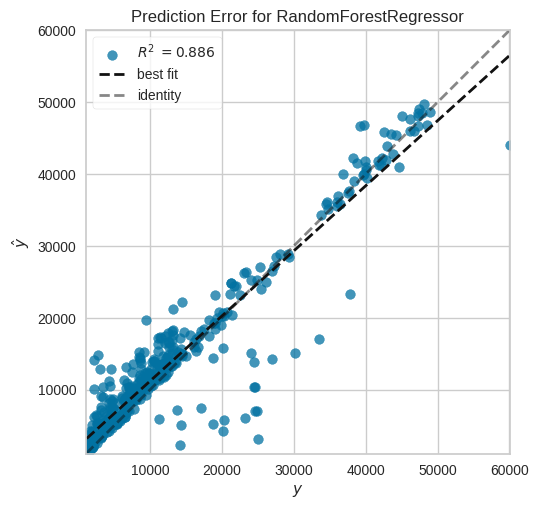

In [75]:
exp.plot_model(best_reg[1], plot="error")

You can get the parameters of the individual models

In [50]:
majority_model_reg.named_estimators['Gradient Boosting Regressor'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 7134,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [66]:
r = majority_model.get_params()["estimators"][0][1]

In [70]:
exp.save_model(majority_model_reg, "out/majority_model_reg")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include...
                                                                     min_impur

In [76]:
new_data = data_reg.drop("charges", axis=1)
new_data.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [78]:
trained = exp.load_model("majority_model_reg")
trained.predict(new_data)

Transformation Pipeline and Model Successfully Loaded


AttributeError: 'VotingRegressor' object has no attribute 'predict_proba'